In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import math
import numpy as np
import torch
from torch.nn import functional as F
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import is_undirected, to_undirected, remove_self_loops, to_dense_adj, dense_to_sparse
import e3nn
from e3nn import o3
from functools import partial

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from src.utils.plot_utils import plot_2d, plot_3d
from src.utils.train_utils import run_experiment
from src.models import MPNNModel, EGNNModel, GVPGNNModel, TFNModel, SchNetModel, DimeNetPPModel, MACEModel, ComENet

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

PyTorch version 1.12.1
PyG version 2.1.0
e3nn version 0.4.4
Using device: cpu


In [3]:
def create_rotsym_envs(fold=3):
    dataset = []

    # Environment 0
    atoms = torch.LongTensor([ 0 ] + [ 0 ] * fold)
    edge_index = torch.LongTensor( [ [0] * fold, [i for i in range(1, fold+1)] ] )
    x = torch.Tensor([1,0,0])
    pos = [
        torch.Tensor([0,0,0]),  # origin
        x,   # first spoke 
    ]
    for count in range(1, fold):
        R = o3.matrix_z(torch.Tensor([2*math.pi/fold * count])).squeeze(0)
        pos.append(x @ R.T)
    pos = torch.stack(pos)
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    q = 2*math.pi/(fold + random.randint(1, fold))
    assert q < 2*math.pi/fold
    Q = o3.matrix_z(torch.Tensor([q])).squeeze(0)
    pos = pos @ Q.T
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

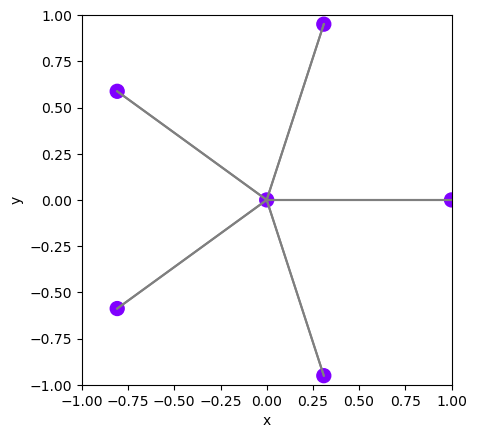

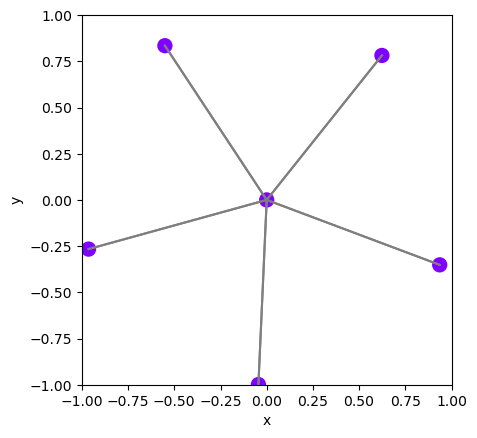

NameError: name 'RadialEmbeddingBlock' is not defined

In [3]:
# Set parameters
model_name = "tfn"# here we can change the model label and run different models
correlation = 2
max_ell = 3
fold = 5

# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

num_layers = 1
model = {
    "mpnn": MPNNModel,
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": partial(TFNModel, max_ell=max_ell, scalar_pred=False),
    "mace": partial(MACEModel, max_ell=max_ell, correlation=correlation, scalar_pred=False),
}[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)

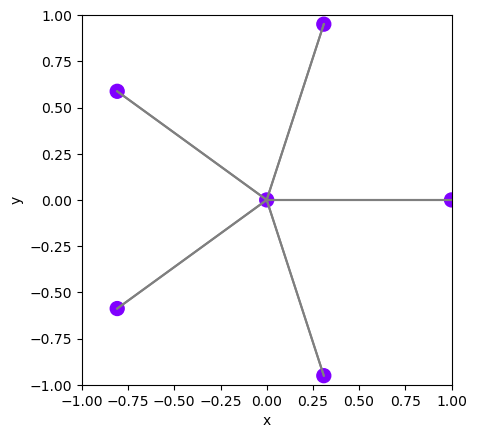

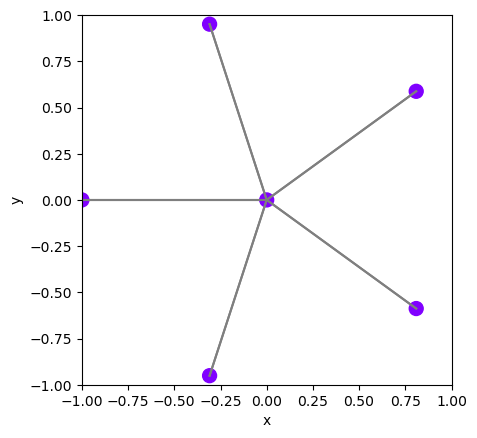

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.48s/it]


Done! Averaged over 10 runs: 
 - Training time: 8.45s ± 0.20. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [4]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
fold=5
# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
num_layers=1
model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )

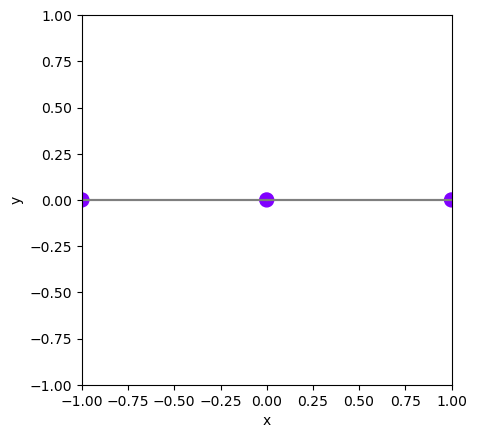

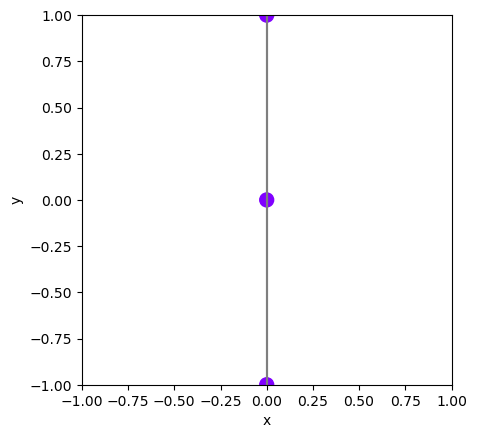

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.30s/it]


Done! Averaged over 10 runs: 
 - Training time: 8.28s ± 0.26. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 



In [5]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
fold=2
# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
num_layers=1
model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )

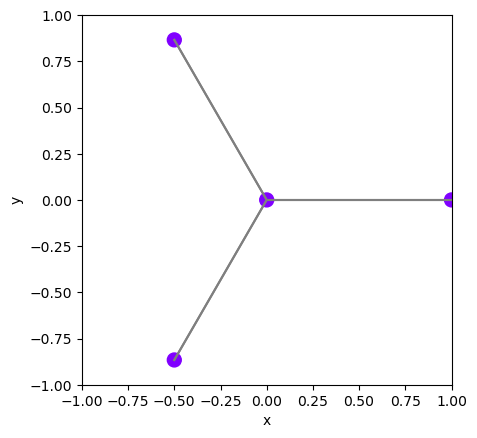

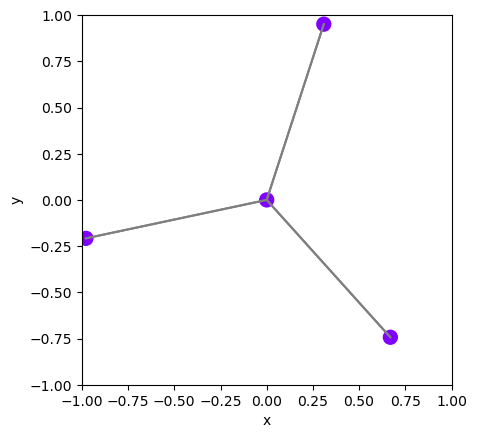

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.19s/it]


Done! Averaged over 10 runs: 
 - Training time: 8.17s ± 0.20. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [6]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
fold=3
# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
num_layers=1
model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )

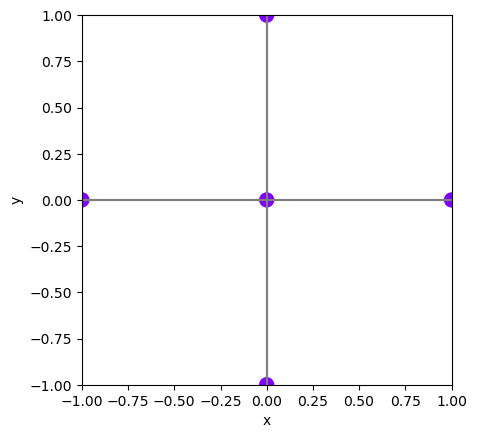

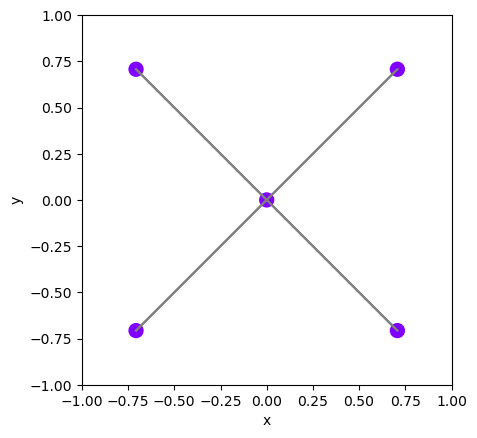

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.24s/it]


Done! Averaged over 10 runs: 
 - Training time: 8.22s ± 0.09. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [7]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
fold=4
# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
num_layers=1
model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )

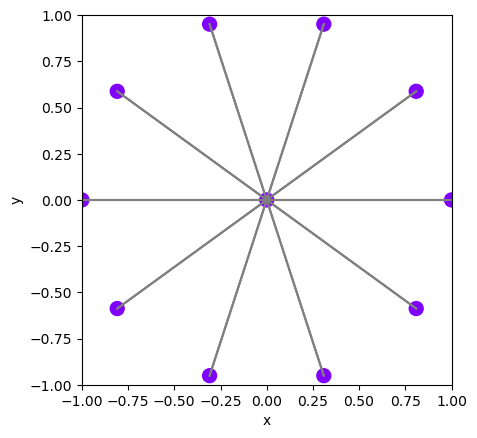

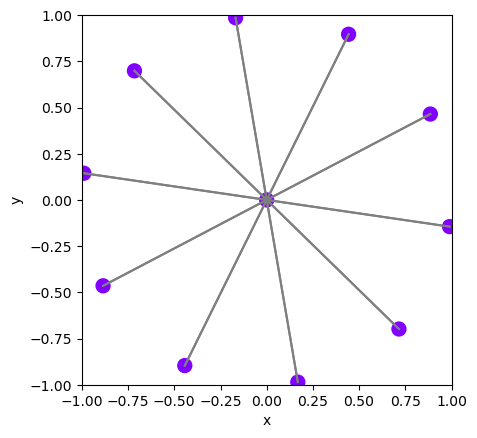

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.08s/it]


Done! Averaged over 10 runs: 
 - Training time: 9.07s ± 0.13. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [9]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
fold=10
# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
num_layers=1
model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )

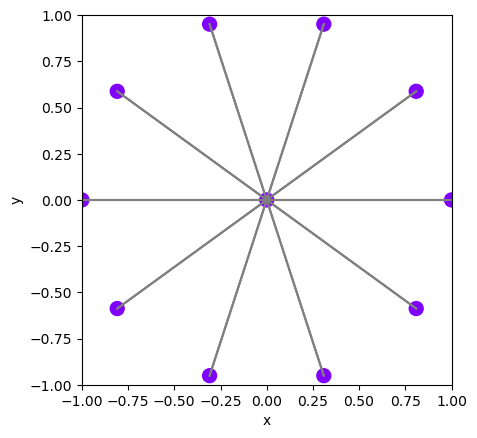

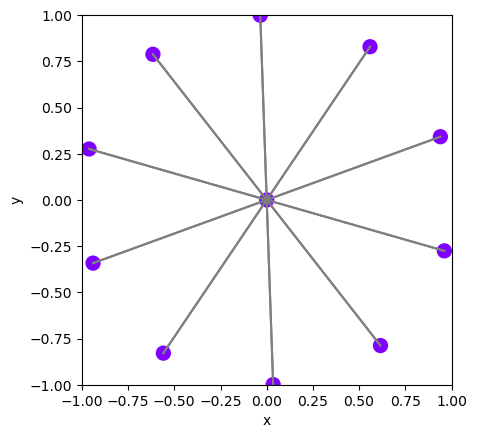

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:19<00:00, 13.98s/it]


Done! Averaged over 10 runs: 
 - Training time: 13.96s ± 0.19. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [10]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
fold=10
# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
num_layers=2
model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )

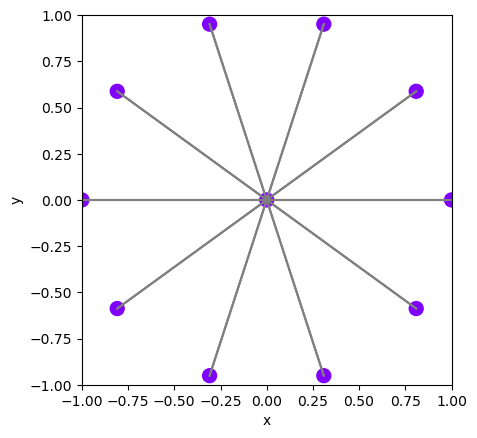

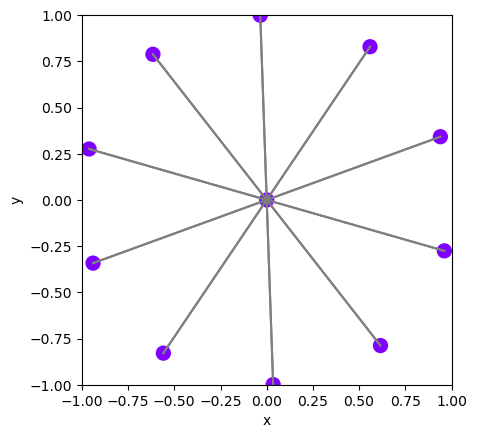

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:11<00:00, 19.14s/it]


Done! Averaged over 10 runs: 
 - Training time: 19.11s ± 0.40. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [11]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
fold=10
# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
num_layers=3
model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )

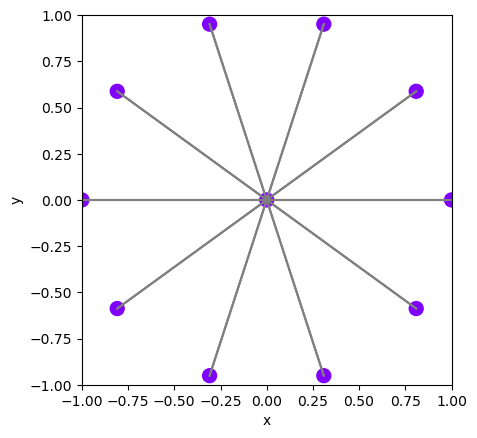

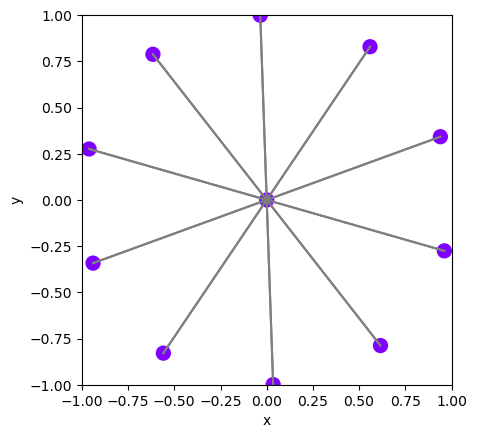

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:44<00:00, 28.46s/it]


Done! Averaged over 10 runs: 
 - Training time: 28.43s ± 0.48. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [12]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
fold=10
# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
num_layers=5
model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )

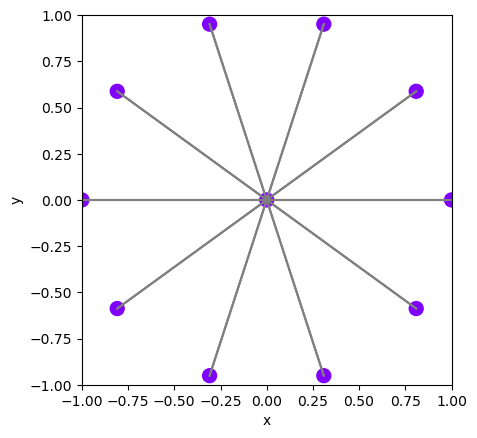

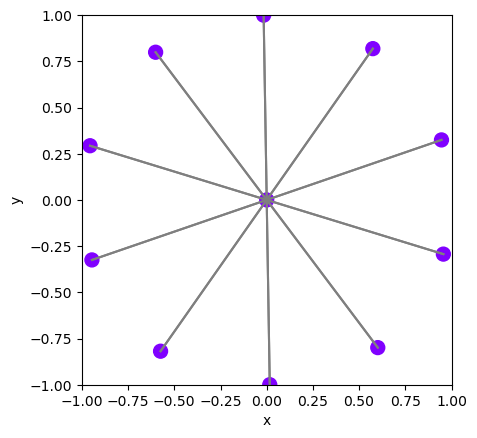

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:39<00:00, 57.92s/it]


Done! Averaged over 10 runs: 
 - Training time: 57.88s ± 5.13. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [4]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
fold=10
# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
num_layers=10
model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )

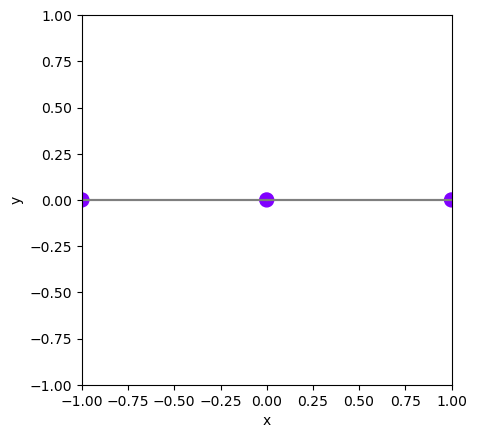

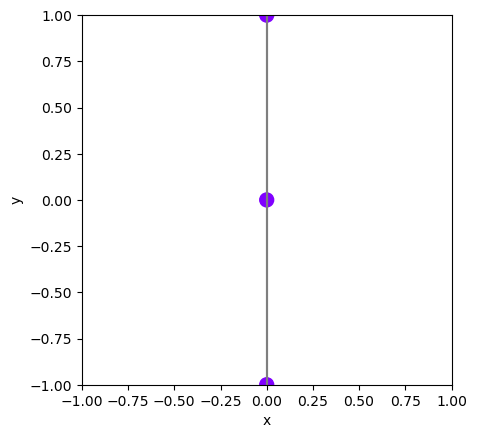

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.68s/it]



Done! Averaged over 10 runs: 
 - Training time: 12.67s ± 0.46. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.75s/it]



Done! Averaged over 10 runs: 
 - Training time: 16.73s ± 0.59. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:25<00:00, 26.59s/it]



Done! Averaged over 10 runs: 
 - Training time: 26.57s ± 2.46. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:38<00:00, 45.81s/it]



Done! Averaged over 10 runs: 
 - Training time: 45.78s ± 0.92. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 



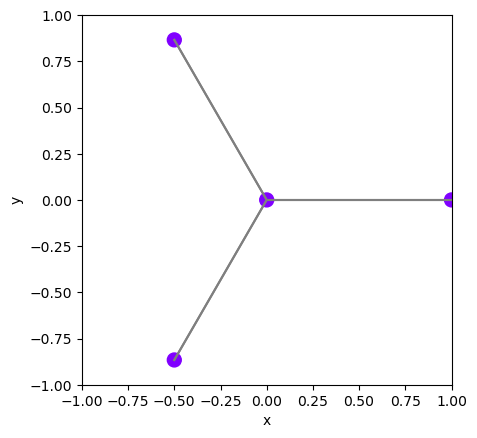

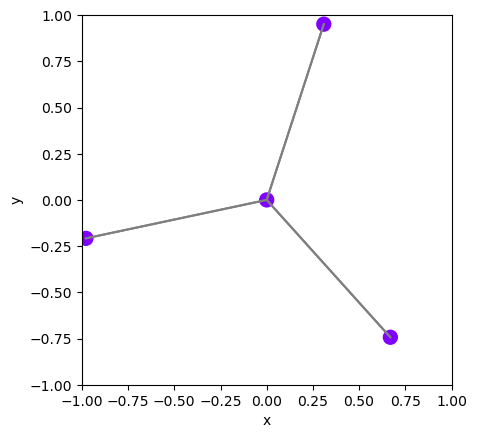

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.24s/it]



Done! Averaged over 10 runs: 
 - Training time: 13.23s ± 1.30. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:50<00:00, 17.02s/it]



Done! Averaged over 10 runs: 
 - Training time: 17.00s ± 0.48. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.64s/it]



Done! Averaged over 10 runs: 
 - Training time: 25.62s ± 1.07. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:48<00:00, 46.81s/it]


Done! Averaged over 10 runs: 
 - Training time: 46.78s ± 4.96. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



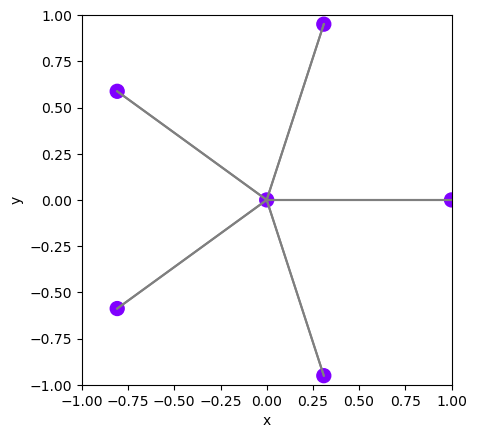

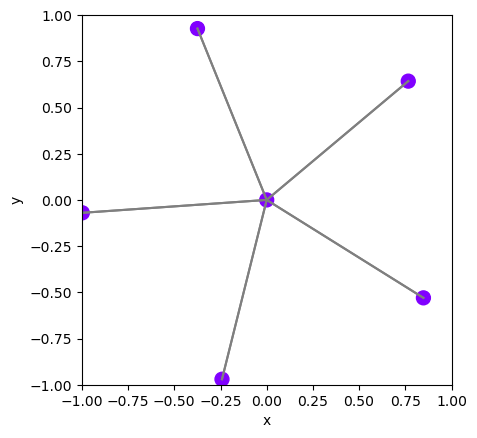

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:20<00:00, 14.04s/it]



Done! Averaged over 10 runs: 
 - Training time: 14.02s ± 0.77. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.81s/it]



Done! Averaged over 10 runs: 
 - Training time: 18.80s ± 1.29. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:46<00:00, 28.67s/it]



Done! Averaged over 10 runs: 
 - Training time: 28.65s ± 1.10. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

Running experiment for ComENet (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:18<00:00, 49.82s/it]


Done! Averaged over 10 runs: 
 - Training time: 49.78s ± 1.81. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [5]:
# Set parameters
model_name = "comenet"# here we can change the model label and run different models
for fold in [2,3,5]:
    # Create dataset
    dataset = create_rotsym_envs(fold)
    for data in dataset:
        plot_2d(data, lim=1)

    # Create dataloaders
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    for num_layers in [2,3,5,10]:
        model = {"comenet": ComENet}[model_name](num_layers=num_layers, out_channels=2)

        best_val_acc, test_acc, train_time = run_experiment(
                model, 
                dataloader,
                val_loader, 
                test_loader,
                n_epochs=100,
                n_times=10,
                device=device,
                verbose=False
            )